In [1]:
import numpy as np
import h5py as h5

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
### mq = get_measured_ldf(mask, qs) / **Det_Area**   ???

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Read and prepare data

In [58]:
h5f = '../../data_01_24.h5'

In [59]:
num = 64

with h5.File(h5f,'r') as hf:
    times_flat = hf['dt_bunlde'][:num,:,:,4:5]*1e6 # in mks
    times_diff = hf['dt_bunlde'][:num,:,:,5:6]*1e6 # in mks
    mask_in = hf['dt_bunlde'][:num,:,:,6:7]
    real_coords = hf['dt_bunlde'][:num,:,:,:3]*1.2 # in km
    qs_in = hf['dt_bunlde'][:num,:,:,3:4]
    ev_params = hf['recos'][:num]
    
mask_qs = tf.where( tf.math.logical_and(mask_in>0, qs_in>0), 1., 0. )

In [60]:
# set c=1, time in mks, distance in km
time2dist = tf.constant(0.299792458, dtype=tf.float32)

times_flat *= time2dist
times_diff *= time2dist

times_reg = times_flat + times_diff

### Shower core, initial

In [61]:
q_max = np.amax(qs_in)*1.1

In [62]:
def get_r_core_sat(qs, coords, mask, mask_qs, fill_val):
    
    qs = tf.where( mask==mask_qs, qs, [fill_val] )
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)
      
def get_r_core(qs, coords):
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)

In [63]:
r_core_sat_0 = get_r_core_sat(qs_in, real_coords[:,:,:,:2], mask_in, mask_qs, q_max) # (bs,1,1,2)
r_core_0 = get_r_core(qs_in, real_coords[:,:,:,:2])

In [64]:
print((r_core_0-r_core_sat_0)[:3,0,0,:]) # small difference since saturated detectors are near the center

tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]], shape=(3, 2), dtype=float32)


In [65]:
print(r_core_sat_0[:3,0,0,:])
print(r_core_0[:3,0,0,:])

tf.Tensor(
[[-0.30211398  0.26573572]
 [-0.03845022 -0.01971256]
 [ 0.00260762 -0.22016773]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[-0.30211398  0.26573572]
 [-0.03845022 -0.01971256]
 [ 0.00260762 -0.22016773]], shape=(3, 2), dtype=float32)


### Linear approximation

In [66]:
# prepare matricies to solve
def make_matrix(coords, times_reg, mask):
    
    # matrix for dL/db
    hs = tf.ones((num,6,6,1)) # to make (x_1,x_2) -> (x_1,x_2,1), to account for b
    coords_ext = mask*tf.concat( (coords,hs), axis=-1 ) # (bs,6,6,3)
    matrix_b = tf.expand_dims( tf.math.reduce_sum( coords_ext, axis=(1,2) ), axis=-1 ) # (bs,3,1)
    times = mask*times_reg # (bs,6,6,1)
    rhs_b = tf.math.reduce_sum( times, axis=(1,2) ) # (bs,1)
    
    # matrix for dL/da
    coords_mul = tf.expand_dims( coords_ext, axis=-1) * tf.expand_dims( coords, axis=-2)
    matrix_a = tf.math.reduce_sum( coords_mul, axis=(1,2) ) # (bs,3,2)
    ts_mul = times * coords
    rhs_a = tf.math.reduce_sum( ts_mul, axis=(1,2) )
    
    matrix = tf.concat((matrix_b,matrix_a), axis=-1)
    rhs = tf.expand_dims( tf.concat((rhs_b,rhs_a), axis=-1), axis=-1 )
    
    return matrix, rhs

In [67]:
def lin_solve(matrix, rhs):
    
    sol_flat = tf.linalg.solve( matrix, rhs, adjoint=True )[:,:,0]
    print(sol_flat)
    t0 = sol_flat[:,2]
    # extract parameters
    n_z = 1. - tf.math.reduce_sum(sol_flat[:,:2]*sol_flat[:,:2], axis=1)
    n_z = tf.where( n_z>0, tf.math.sqrt( n_z ), 0. ) # some configurations yield front moving faster than light
    theta_flat = tf.math.acos( n_z )
    phi_flat = tf.math.atan2( -sol_flat[:,1], -sol_flat[:,0] )
    
    return theta_flat, phi_flat, t0

In [68]:
matrix, rhs = make_matrix(real_coords[:,:,:,:2], times_reg, mask_qs)
theta_flat, phi_flat, t0_flat = lin_solve(matrix, rhs) # (bs,)
phi_flat = tf.where( phi_flat>0, phi_flat, 3.1415*2 + phi_flat  )

tf.Tensor(
[[ 1.94365281e+05 -5.27451625e+05  1.93256453e+05]
 [ 5.83730938e+05  3.06786328e+04  1.51503234e+05]
 [ 1.69319781e+05 -2.25759277e+04  2.28110234e+05]
 [-1.34247375e+05  1.02333766e+05  4.41834000e+05]
 [-3.41419812e+05  5.38652893e+02  2.27203266e+05]
 [ 1.19045469e+05  1.61439014e+03  2.04585109e+05]
 [-6.62905000e+04 -4.71816211e+04  1.27207484e+05]
 [-3.31798156e+05 -4.95958867e+04  2.92045094e+05]
 [ 1.76714258e+04  2.91321625e+05  2.61974906e+05]
 [ 2.02916172e+05 -7.86245859e+04  3.16326719e+05]
 [-5.65876500e+05  3.72428281e+05  2.97586750e+05]
 [-4.31444531e+04 -4.78346031e+05  4.02160812e+05]
 [-6.27121938e+05  1.26379164e+05  2.43055547e+05]
 [-1.18420219e+05  4.88306688e+05  1.95091875e+05]
 [ 7.59783125e+04 -3.03305156e+05  1.22048852e+05]
 [ 4.69426875e+05 -1.10562266e+05  2.61070906e+05]
 [-3.36520875e+05  3.16676281e+05  3.41831844e+05]
 [ 4.54308219e+05  3.47532125e+05  2.34211828e+05]
 [-5.29753062e+05 -2.67297241e+03  1.59693000e+05]
 [ 5.28639188e+05 -1

In [69]:
theta_rec = ev_params[:num,2]/180*3.1415
phi_rec = ev_params[:num,3]/180*3.1415

In [70]:
print(theta_rec[:5])
print(theta_flat[:5].numpy())

[0.07382543 0.08574376 0.1362938  0.14861791 0.11598436]
[1.5707964 1.5707964 1.5707964 1.5707964 1.5707964]


In [71]:
print(phi_rec[:5])
print(phi_flat[:5].numpy())

[0.03144362 0.03644769 0.08272914 0.10213749 0.06431471]
[1.9238552 3.1939151 3.0090413 5.631687  6.281422 ]


In [72]:
t0_ext_ch = t0_flat[:,tf.newaxis,tf.newaxis]
nx = - tf.math.sin(theta_flat)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi_flat)[:,tf.newaxis,tf.newaxis]
ny = - tf.math.sin(theta_flat)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi_flat)[:,tf.newaxis,tf.newaxis]
# nz = tf.math.cos(theta_flat)[:,tf.newaxis,tf.newaxis]
a = tf.concat((nx,ny), axis=-1)
# a = tf.concat((a,nz), axis=-1)
a = tf.expand_dims( a, axis=1 )

t_rec = t0_ext_ch + tf.math.reduce_sum( a*real_coords[:,:,:,:2], axis=-1 )
t_rec = t_rec*mask_in[:,:,:,0]

In [73]:
diff = times_reg[:,:,:,0]*mask_qs[:,:,:,0]-t_rec
print(tf.reduce_sum(diff, axis=(1,2)))

tf.Tensor(
[-1161116.     -518197.2     622288.6     756613.1    1883906.
     3783.5     107255.66    702980.3    1088205.5     330695.5
  1019143.75   -418883.53   1817196.1     515853.44  -1082180.8
  -205966.78    289950.72   -536171.6     847886.6    -773915.25
 -1083733.4    -142969.25   1289158.4     539117.1   -1044828.4
  -775178.94    937199.2   -1584282.4    -851070.25   -179951.69
  2566506.8    -261711.1    1985467.8     -72707.19     31145.375
    95842.75   -160384.31   1147741.4    1055798.      534625.
   812207.44    381007.44    471021.03   -121462.75     97817.05
   276702.       -5303.875    31524.688   -94011.03    410987.8
   332435.44   -398104.12    -66837.78    915750.25   -139409.38
   -87842.125  -137385.88    -73083.44     52549.812  2163841.2
  -224016.75    -22118.875   -44708.062   162990.62 ], shape=(64,), dtype=float32)


In [20]:
diff = tf.math.abs(times_reg[:,:,:,0]*mask_qs[:,:,:,0]-t_rec)
print(tf.reduce_sum(diff, axis=(1,2))/tf.reduce_sum(mask_qs[:,:,:,0], axis=(1,2)))

tf.Tensor(
[0.10118219 0.1089315  0.20253925 0.35319355 0.11736246 0.25390136
 0.08409789 0.2064849  0.1975056  0.34670734 0.26725373 0.10407462
 0.08335411 0.3183393  1.0593617  0.2990111  0.0831734  0.20299003
 0.04378579 0.15864886 0.04055079 0.13750985 0.12065328 0.2244104
 0.34522566 0.12849776 0.1275013  0.21244767 0.5705006  0.07331727
 0.5690793  0.09886026 0.20316596 0.08108567 0.36974138 0.154049
 0.3673324  0.10409182 0.11426502 0.7217716  0.12717076 0.2597414
 0.21678165 0.4350091  0.19198945 0.19539404 0.05313609 0.32304367
 0.12754351 0.14420262 0.6141158  1.7418705  0.17269109 0.21208388
 0.15527344 0.10184619 0.05864263 0.28793675 0.26712793 0.40014043
 0.12685588 0.06280586 1.6369988  0.123521  ], shape=(64,), dtype=float32)


In [21]:
diff = tf.math.abs(times_flat[:,:,:,0]*mask_qs[:,:,:,0]-t_rec)
print(tf.reduce_sum(diff, axis=(1,2))/tf.reduce_sum(mask_qs[:,:,:,0], axis=(1,2)))

tf.Tensor(
[0.20959783 0.2491904  0.29979244 0.46025634 0.22600068 0.5615435
 0.21208236 0.3837521  0.30413944 0.5434806  0.39171636 0.22527264
 0.25122324 0.49563184 0.8944951  0.5041607  0.20514372 0.30792856
 0.21039082 0.2998451  0.21259886 0.3003548  0.2123761  0.29086298
 0.65118724 0.30259255 0.26660118 0.29097    0.6283361  0.25731772
 1.111545   0.29811305 0.44951534 0.23422359 0.48266825 0.35602495
 0.45696634 0.19953333 0.30399272 0.9878     0.24123335 0.39388442
 0.32432398 0.7449414  0.49496242 0.3955919  0.19893165 0.5378073
 0.2446798  0.27781522 0.8566028  1.7153467  0.36108875 0.38223526
 0.3163981  0.4180154  0.18116035 0.45855767 0.49706036 0.61922365
 0.31778312 0.22721304 1.4874202  0.2791607 ], shape=(64,), dtype=float32)


In [22]:
t0_ext_ch = t0_flat[:,tf.newaxis,tf.newaxis]
nx =  tf.math.sin(theta_rec)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi_rec)[:,tf.newaxis,tf.newaxis]
ny =  tf.math.sin(theta_rec)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi_rec)[:,tf.newaxis,tf.newaxis]
# nz =  tf.math.cos(theta_rec)[:,tf.newaxis,tf.newaxis] 
a = tf.concat((nx,ny), axis=-1)
# a = tf.concat((a,nz), axis=-1)
a = tf.expand_dims( a, axis=1)
t_rec = t0_ext_ch + tf.math.reduce_sum( a*real_coords[:,:,:,:2], axis=-1 )
t_rec = t_rec*mask_in[:,:,:,0]

In [23]:
def norm_const(data):
    #shape b,6,6
    m=tf.reduce_min(data,axis=(1,2))[:,tf.newaxis,tf.newaxis]
    return tf.where(data!=0,data-m,0)

In [24]:
norm_const(times_flat[:,:,:,0]*mask_qs[:,:,:,0])[:2] - norm_const(t_rec[:2])

<tf.Tensor: shape=(2, 6, 6), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.3234228 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.68942094,  0.33484584,
         -0.01837397,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.29531562,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.6517277 ,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -1.1545774 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.6689595 , -0.69463134,
          0.5

In [25]:
times_flat.shape

TensorShape([64, 6, 6, 1])

In [26]:
(times_flat[:,:,:,0]*mask_qs[:,:,:,0])[:10] - t_rec[:10]

<tf.Tensor: shape=(10, 6, 6), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.41621315,
         -0.73963594,  0.        ],
        [ 0.        ,  0.        , -0.05021497, -0.40479004,
         -0.7580099 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.44432035,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.08790815,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -1.4708228 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.985205  , -0.31625763,
          0.

In [27]:
diff = tf.math.abs(times_reg[:,:,:,0]*mask_qs[:,:,:,0]-t_rec)
print(tf.reduce_sum(diff, axis=(1,2))/tf.reduce_sum(mask_qs[:,:,:,0], axis=(1,2)))

tf.Tensor(
[0.33780378 0.8385002  1.0697865  0.5298703  0.50468665 1.4404854
 0.4413312  0.9344003  0.69621634 0.42085034 0.359538   0.4988852
 1.2250637  0.37252808 1.3646446  0.9700557  0.6308561  1.3745422
 0.37079042 0.6060708  0.93294686 0.83640426 0.30973452 0.52382714
 0.42700285 0.21177241 0.5346812  0.3681648  0.74378145 0.8309407
 0.92892736 0.3893106  0.44841275 0.22688846 0.655149   0.5135215
 0.72955054 0.19569325 0.24424267 0.80545944 0.3943959  0.61710435
 0.5402409  0.68076485 0.18714333 0.4297542  0.26822567 0.70215064
 0.26185256 0.83002716 1.0199969  1.7097206  0.8266812  0.49381268
 0.59338075 0.873635   0.53900224 0.2777193  1.0295748  0.59572536
 1.4585447  0.48960736 1.6701157  0.7591628 ], shape=(64,), dtype=float32)


In [28]:
diff = tf.math.abs(times_flat[:,:,:,0]*mask_qs[:,:,:,0]-t_rec)
print(tf.reduce_sum(diff, axis=(1,2))/tf.reduce_sum(mask_qs[:,:,:,0], axis=(1,2)))

tf.Tensor(
[0.4144418  0.8014639  1.1228926  0.77555025 0.52206177 1.9772637
 0.2824037  1.0203224  0.79878306 0.404977   0.39734146 0.4504902
 1.1336699  0.5583589  1.2209958  1.252962   0.58148557 1.2225046
 0.27580988 0.4619863  0.96692324 0.76496804 0.33120808 0.65389425
 0.6020886  0.30313373 0.60106033 0.4298907  0.88247347 0.99033386
 1.161687   0.39440703 0.7113342  0.2695825  0.7543537  0.73342264
 0.72287977 0.23195603 0.36368838 1.3027338  0.517268   0.6511093
 0.7337783  1.1655794  0.51238716 0.50492024 0.3254206  0.7915652
 0.28385034 0.76051813 0.9902329  1.6200744  0.69342405 0.67377955
 0.54791224 0.9576268  0.48820874 0.24434505 1.0329417  0.6980211
 1.4824531  0.47211945 1.1423812  0.89389646], shape=(64,), dtype=float32)


In [29]:
t_rec[:2]

<tf.Tensor: shape=(2, 6, 6), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.6609411 ,
         -0.93200696,  0.        ],
        [ 0.        ,  0.        ,  0.14764751, -0.10905427,
         -0.3656123 ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.40684628,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.2547005 ,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.97166836,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.29058582,  0.31625763,
          0.3

### S_800 reco

In [30]:
theta_flat = theta_flat[:,tf.newaxis, tf.newaxis]
phi_flat = phi_flat[:,tf.newaxis, tf.newaxis]
t0_flat = t0_flat[:,tf.newaxis,tf.newaxis]

In [31]:
def get_eta(theta):
    
    x = theta*180.0/3.1415
    
    e1 = 3.97 - 1.79*(tf.math.abs(1.0/(tf.math.abs(tf.math.cos(theta))+1e-6)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
    # valid ???
    #res = tf.where(res>0,res,0)
    
    return res

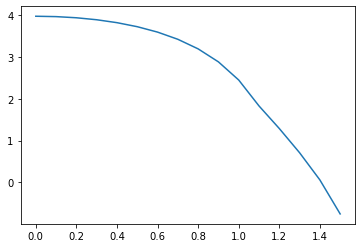

In [32]:
ts = np.arange(0., 3.141/2, 0.1)
es = get_eta(ts)

plt.plot(ts,es)

In [33]:
Rm = tf.constant([0.09])
R1 = tf.constant([1.])

def get_profile(r, eta):

    res = tf.math.pow(((r+1e-6)/Rm),-1.2) * tf.math.pow((1+r/Rm), -(eta-1.2)) * tf.math.pow(1.+(tf.math.pow(r,2)/R1/R1),-0.6)
    return res

In [34]:
R_x = tf.constant([[0.8]])

# r should be centered at shower's core
# normed so that ldf(800m)=1
def get_normed_ldf(r, eta):
    
    norm = get_profile(R_x, eta)
    ldf = get_profile(r, eta)
    
    if tf.math.reduce_any( tf.math.is_nan( norm )):
            print('ldf norm Nan') 
    if tf.math.reduce_any( tf.math.is_nan( ldf )):
            print('ldf ldf Nan') 
    
    return ldf/norm
    #return tf.math.divide_no_nan(ldf,norm)

In [35]:
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])

Det_Area = 3.0

def get_S_norm_raw(qs, coords, r_core, theta, phi, mask, eta):
    # calculate distance to shower core
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2)
    dist_core = tf.where( dist_core>0, tf.math.sqrt( dist_core ), 0. )
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask[:,:,:,0]*mask_dist
    #mask = mask[:,:,:,0]
    
    mq = get_measured_ldf(mask, qs)
    eq = get_expected_ldf(dist_core, eta, mask)
    
    return mq, eq

def get_measured_ldf(mask, qs):

    return tf.math.reduce_sum( qs*mask, axis=(1,2) ) / Det_Area

def get_expected_ldf(dist_core, eta, mask):
    
    exp_qs = get_normed_ldf(dist_core, eta)*mask
    if tf.math.reduce_any( tf.math.is_nan( exp_qs )):
            print('exp_qs Nan eval')
    
    return tf.math.reduce_sum( exp_qs, axis=(1,2) )

In [36]:
eta_flat = get_eta(theta_flat)
mq, eq = get_S_norm_raw(qs_in[:,:,:,0], real_coords[:,:,:,:2], r_core_0, theta_flat, phi_flat, mask_qs, eta_flat)
S_norm_ch = mq/(eq+1e-8)

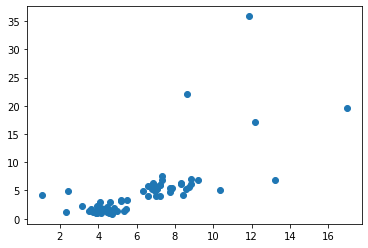

In [37]:
plt.scatter(mq,eq)

In [38]:
# mc_th = ev_params[:num,8:9][:,tf.newaxis]/180*3.1415
# mc_phi = ev_params[:num,9:10][:,tf.newaxis]/180*3.1415
# print(mc_th.shape,mc_phi.shape)

In [39]:
# eta_mc = get_eta(mc_th)
# mq, eq = get_S_norm_raw(qs_in[:,:,:,0], real_coords[:,:,:,:2], np.zeros_like(real_coords)[:,0:1,0:1,:2], mc_th, mc_phi, mask_qs, eta_mc)
# S_norm_ch = mq/(eq)

In [40]:
# plt.scatter(mq,eq)

### Full time reco

In [41]:
def get_a_ivanov(theta, rescale):
    
    theta_degr = theta/3.1415*180.
    
    r1 = 3.3836 - 0.01848*theta_degr
    r2 = (0.6511268210e-4*(theta_degr-.2614963683))*(theta_degr*theta_degr-134.7902422*theta_degr+4558.524091)
    r3 = tf.math.exp(-3.2e-2*theta_degr + 2.0)
    
    a_ivanov = tf.where( theta_degr<25.0, r1, r2 )
    a_ivanov = tf.where( theta_degr>35.0, r3, a_ivanov )
    
    if rescale:
        a_ivanov *= 1.3
    
    return a_ivanov

def get_S_norm(dist_core, mask, qs, eta):
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask*mask_dist
    if tf.math.reduce_any( tf.math.is_nan( mask )):
            print('mask Nan eval')
    
    mq = get_measured_ldf(mask, qs)
    if tf.math.reduce_any( mq==0 ):
            print('mq =0 eval')
    eq = get_expected_ldf(dist_core, eta, mask)
    if tf.math.reduce_any( tf.math.is_nan( eq )):
            print('eq Nan eval')
    
    return mq/(eq+1e-6)

In [42]:
# changed to - in plane
R_L = 0.03
R_error = 0.15

def get_lins_t(r, s):
    return 0.67*tf.math.pow((1 + r/R_L), 1.5)*tf.math.pow(s+1e-8, -0.5)

def get_exp_time(t0, theta, phi, coords, mask, r_core, qs, rescale):
    # flat
    t_plane = t0 - tf.math.sin(theta)*( tf.math.cos(phi)*coords[:,:,:,0] + tf.math.sin(phi)*coords[:,:,:,1] ) - tf.math.cos(theta)*coords[:,:,:,2]
    if tf.math.reduce_any( tf.math.is_nan( t_plane )):
            print('t_plane Nan eval')
    ## curvature
    # get S_800
    cent_coords = coords[:,:,:,:2] - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] ) + tf.math.cos(theta)*coords[:,:,:,2]
    dist_core = tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2)
    dist_core = tf.where( dist_core>0, tf.math.sqrt( dist_core ), 0. )
    # IS THIS ALSO NESSASARY?
    dist_core = tf.where( dist_core>R_error, dist_core, R_error )
    eta = get_eta(theta)
    if tf.math.reduce_any( tf.math.is_nan( eta )):
            print('eta Nan eval')
    S_norm = get_S_norm(dist_core, mask, qs, eta)[:,tf.newaxis, tf.newaxis]
    if tf.math.reduce_any( tf.math.is_nan( S_norm )):
            print('S_norm Nan eval')
    if tf.math.reduce_any( S_norm<0 ):
            print('S_norm <0 eval')
    if tf.math.reduce_any( S_norm==0 ):
            print('S_norm =0 eval')
    # get curv parameters
    a_ivanov = get_a_ivanov(theta, rescale)
    if tf.math.reduce_any( tf.math.is_nan( a_ivanov )):
            print('a_ivanov Nan eval')
    aprime = a_ivanov/tf.math.sqrt(S_norm)
    if tf.math.reduce_any( tf.math.is_nan( aprime )):
            print('aprime Nan eval')
    s_prof = get_normed_ldf(dist_core, theta)
    if tf.math.reduce_any( tf.math.is_nan( s_prof )):
            print('s_prof Nan eval')
    # time due to curvature
    t_curv = aprime*get_lins_t( dist_core, s_prof )
    if tf.math.reduce_any( tf.math.is_nan( t_curv )):
            print('s_prof Nan eval')
    
    return ( t_plane + t_curv * 1e-3*time2dist )*mask # nsec -> mks -> km 

In [43]:
ts = get_exp_time(t0_flat, theta_flat, phi_flat, real_coords[:,:,:,:3], mask_qs[:,:,:,0], r_core_sat_0, qs_in[:,:,:,0], True)

In [44]:
t0_err = 30.
t_err_resc = tf.math.pow( 1e-3*time2dist, 2 )

def get_linsley_s(r, S):
    return 1.3*0.29*tf.math.pow((1 + r/R_L), 1.5)*pow(S+1e-6, -0.3)

def get_t_err(aprime, S_norm, r, eta):
    s_prof = get_profile(r, eta)
    lin_s = get_linsley_s( r, S_norm*s_prof )
    t_s = aprime*tf.math.sqrt(S_norm)*lin_s
    return (t0_err*t0_err + t_s*t_s) * t_err_resc # ns^2 -> mks^2 -> km^2

In [45]:
def  get_expected_q(t_0, thetta, phi, coords, r_core, S_norm):
    
    t_plane = t_0 - tf.math.sin(thetta)*( tf.math.cos(phi)*coords[:,:,:,0] + tf.math.sin(phi)*coords[:,:,:,1] )
    if tf.math.reduce_any( tf.math.is_nan( t_plane )):
        print('plane Nan in')
    cent_coords = coords[:,:,:,:2] - r_core
    if tf.math.reduce_any( tf.math.is_nan( cent_coords )):
        print('r_core Nan in')  
    proj_to_n = tf.math.sin(thetta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] ) + tf.math.cos(thetta)*coords[:,:,:,2]
    if tf.math.reduce_any( tf.math.is_nan( proj_to_n )):
        print('proj Nan in')
    dist_core = tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2)
    dist_core = tf.where( dist_core>0, tf.math.sqrt( dist_core ), 0. )
    # IS THIS ALSO NESSASARY?
    dist_core = tf.where( dist_core>R_error, dist_core, R_error )
    if tf.math.reduce_any( tf.math.is_nan( dist_core )):
        print('dist_core Nan in')
    eta = get_eta(thetta)
    s_prof = get_normed_ldf(dist_core, eta)
    s_expt = S_norm*s_prof
    return s_expt

### Gradient descendent

In [46]:
# get initial: aprime, S_800
def init_vars(theta, phi, coords, mask, r_core, qs, rescale):
    
    cent_coords = coords[:,:,:,:2] - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    eta = get_eta(theta)
    S_norm = get_S_norm(dist_core, mask, qs, eta)[:,tf.newaxis, tf.newaxis]
    # get curv parameters
    a_ivanov = get_a_ivanov(theta, rescale)
    aprime = a_ivanov/tf.math.sqrt(S_norm)
    
    return aprime, S_norm

In [47]:
aprime_init, S_norm_init = init_vars( theta_flat, phi_flat, real_coords[:,:,:,:3], mask_qs[:,:,:,0], r_core_sat_0, qs_in[:,:,:,0], True )

In [48]:
aprime_init

<tf.Tensor: shape=(64, 1, 1), dtype=float32, numpy=
array([[[3.470824  ]],

       [[2.2276804 ]],

       [[2.0998054 ]],

       [[3.3438952 ]],

       [[2.5654454 ]],

       [[1.9159312 ]],

       [[2.5877671 ]],

       [[1.6522739 ]],

       [[1.8890294 ]],

       [[3.163911  ]],

       [[4.649707  ]],

       [[2.6174002 ]],

       [[1.8294905 ]],

       [[1.9089719 ]],

       [[2.7317376 ]],

       [[1.9112891 ]],

       [[2.7152843 ]],

       [[2.742577  ]],

       [[2.4908638 ]],

       [[1.5166676 ]],

       [[1.9393828 ]],

       [[1.8904628 ]],

       [[2.561862  ]],

       [[1.8264297 ]],

       [[1.8421997 ]],

       [[2.6971772 ]],

       [[6.5654693 ]],

       [[3.3169296 ]],

       [[1.702898  ]],

       [[2.018732  ]],

       [[1.3839806 ]],

       [[1.742648  ]],

       [[3.3739145 ]],

       [[2.761984  ]],

       [[2.3989627 ]],

       [[2.7272167 ]],

       [[1.8493538 ]],

       [[2.86537   ]],

       [[3.1377292 ]],

       [[1.9

In [49]:
exp_qs = get_expected_q(t0_flat, theta_flat, phi_flat, real_coords[:,:,:,:3], r_core_sat_0, S_norm_init)

In [50]:
print((exp_qs*mask_qs[0,:,:,0])[0])
print(qs_in[0,:,:,0])

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.17748055  0.05192861  0.        ]
 [ 0.          0.          0.4145333  11.053725    0.06990292  0.        ]
 [ 0.          0.          0.          0.17242149  0.          0.        ]
 [ 0.          0.          0.02238672  0.          0.          0.        ]], shape=(6, 6), dtype=float32)
[[ 0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        1.24868   0.477705  0.      ]
 [ 0.        0.        8.35528  10.5188    0.698082  0.      ]
 [ 0.        0.        0.        3.40935   0.        0.      ]
 [ 0.        0.        1.22881   0.        0.        0.      ]]


In [51]:
opt_params_var = []

for p in [t0_flat, theta_flat, phi_flat, r_core_sat_0, aprime_init, S_norm_init]:
    opt_params_var.append( tf.Variable(p, True) )

In [52]:
# opt_params_var = []

# for p in [t0_flat, theta_mc, phi_mc, r_core_sat_0, aprime_init, S_norm_init]:
#     opt_params_var.append( tf.Variable(p, True) )

In [53]:
# rewrite to individual loss?

def chi2_loss(predicted, real, mask, error):
        
    if tf.math.reduce_any( tf.math.is_nan( predicted )):
        print('loss Nan in')
    if tf.math.reduce_any( tf.math.is_nan( error )):
        print('error Nan in')
    n_points = tf.math.reduce_sum( mask, axis=(1,2), keepdims=False )
    chi2 = tf.math.reduce_sum( (predicted-real)*(predicted-real)/error*mask, axis=(1,2) )
    if tf.math.reduce_any( tf.math.is_nan( chi2 )):
        print('loss Nan out')

    return chi2, n_points 

In [54]:
class chi2_accumulate(tf.keras.losses.Loss):

    def __init__(self, n_pars):
        self.n_pars = n_pars
        super().__init__()
        
    def __call__(self, losses, n_points):
        
        loss = tf.stack(losses, axis=0)
        loss = tf.math.reduce_sum( loss )
        
        n_ps = tf.stack(n_points, axis=0)
        n_ps = tf.math.reduce_sum( n_ps )
        
        n_ps = n_ps - self.n_pars
        n_ps = tf.where( n_ps>0, n_ps, 1. )
        
        return loss/n_ps
    
loss_fn = chi2_accumulate(7) # 7 for joint fit, 4 for geometry

In [55]:
def logPua(n, nbar):
    
    mask_nbar_0 = tf.where( nbar< 1e-40, True, False )
    mask_n_0 = tf.where( n>1e-40, True, False )
    mask_n_0 = tf.logical_and( mask_nbar_0, mask_n_0 )
    
    mask_n = tf.where( n<1e-20, True, False )
    mask_n = tf.logical_and( ~mask_nbar_0, mask_n )
    
    mask_res = tf.logical_and( ~mask_nbar_0, ~mask_n )
    
    res = tf.zeros_like(n)
    
    res = tf.where( mask_n_0, -1.*1e-6, 0. )
            
    res = tf.where( mask_n,  -2*nbar, res )

    res = tf.where( mask_res, 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar)), res )
    
    return res

def logPau_loss(q_reg, q_exp, mask):
    
    loss = tf.math.reduce_sum( (-0.4*logPua(q_reg*Det_Area, q_exp*Det_Area))*mask, axis=(1,2) )
    if tf.math.reduce_any( tf.math.is_nan( loss )):
            print('loss Nan eval')  
    n_ps = tf.math.reduce_sum( mask, axis=(1,2), keepdims=False )
    return loss, n_ps

In [56]:


# - in t plane
def opt_step(opt_params, coords, mask, qs, do_print):

    with tf.GradientTape(persistent=True) as tape:

        tape.watch( opt_params )

        # time reco
        t_plane = opt_params[0] - tf.math.sin(opt_params[1])*( tf.math.cos(opt_params[2])*coords[:,:,:,0] + tf.math.sin(opt_params[2])*coords[:,:,:,1] )
        if tf.math.reduce_any( tf.math.is_nan( t_plane )):
            print('plane Nan in')
        cent_coords = coords[:,:,:,:2] - opt_params[3]
        if tf.math.reduce_any( tf.math.is_nan( cent_coords )):
            print('r_core Nan in')  
        proj_to_n = tf.math.sin(opt_params[1])*( tf.math.cos(opt_params[2])*cent_coords[:,:,:,0] + tf.math.sin(opt_params[2])*cent_coords[:,:,:,1] ) + tf.math.cos(opt_params[1])*coords[:,:,:,2]
        if tf.math.reduce_any( tf.math.is_nan( proj_to_n )):
            print('proj Nan in')
        dist_core = tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2)
        if tf.math.reduce_any( dist_core<-0.1 ):
            print('dist_core <-0.1 eval')
        dist_core = tf.where( dist_core>0, tf.math.sqrt( dist_core ), 0. )
        # IS THIS ALSO NESSASARY?
        dist_core = tf.where( dist_core>R_error, dist_core, R_error )
        if tf.math.reduce_any( tf.math.is_nan( dist_core )):
            print('dist_core Nan in')
        eta = get_eta(opt_params[1])
        s_prof = get_normed_ldf(dist_core, eta)
        if tf.math.reduce_any( tf.math.is_nan( s_prof )):
            print('plane Nan in')
        # time due to curvature
        t_curv = opt_params[4]*get_lins_t( dist_core, s_prof )
        if tf.math.reduce_any( tf.math.is_nan( t_curv )):
            print('curve Nan in')

        # geometry
        # WHAT IS S REALLY IN R. CODE? and is this really nessesary?
        mask_q = tf.where( qs>0.1, 1., 0. )
        mask_t = mask_q * mask
        t_res = (t_plane + t_curv * 1e-3*time2dist )*mask_t         
        t_err = get_t_err( opt_params[4], opt_params[5], dist_core, eta )
        loss_t, n_ps_t = chi2_loss( t_res, times_reg[:,:,:,0], mask_t, t_err )
        #print(loss_t)
        
        # Q
        s_expt = opt_params[5]*s_prof
        if tf.math.reduce_any( tf.math.is_nan( s_expt )):
            print('s_expt Nan in')
        # q2
        mask_q2 = tf.where( s_expt>4., 1., 0 ) # error
        mask_q2 = mask_q2*mask_t
        if tf.math.reduce_any( tf.math.is_nan( mask_q2 )):
            print('mask_q2 Nan in')
        error_q2 = ( 2*qs/Det_Area + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
        if tf.math.reduce_any( tf.math.is_nan( error_q2 )):
            print('error_q2 Nan in')
        loss_q2, n_ps_q2 = chi2_loss( s_expt, qs, mask_q2, error_q2 )
        print(loss_q2[1])
        print(s_expt[1] - qs[1])
        print( s_expt[1], qs[1])
        # q3
        mask_q3 = tf.where( s_expt<4., 1., 0 )
        mask_q3 = mask_t*mask_q3
        loss_q3, n_ps_q3 = logPau_loss( qs, s_expt, mask_q3 )
        
        # accumulate
        loss = loss_fn( [loss_t,loss_q2,loss_q3], [n_ps_t,n_ps_q2,n_ps_q3] )
        #print(loss)
        mask_big_a = tf.where( opt_params[4]>2., 1., 0. )
        reg_a = mask_big_a*( opt_params[4]-2. )*100.
        loss += reg_a

        #n_ps_q2 = tf.where( n_ps_q2-7.>0., n_ps_q2-7, 1.  )
        #print(tf.math.reduce_sum( loss_t/n_ps_q2 ), tf.math.reduce_sum( loss_q2/n_ps_q2 )   , end='\r')
        if do_print:
            print(tf.math.reduce_sum( loss_t ), tf.math.reduce_sum( loss_q2 ), tf.math.reduce_sum( loss_q3 ), end='\r')
           # print( tf.math.reduce_sum( loss_q3 ) , tf.math.reduce_sum( n_ps_q3 )   , end='\r' )
        #print(loss, end='\r')
        
    # update weights
    grads = tape.gradient(loss, opt_params)
    for j,g in enumerate(grads):
        if tf.math.reduce_any( tf.math.is_nan( g )):
            print('grads Nan, '+str(j))
#     grads[1] = 5.0*grads[1]
#     grads[2] = 5.0*grads[2]
    #print(grads)
    optimizer.apply_gradients( zip(grads, opt_params) )

In [57]:
opt_params_var

[<tf.Variable 'Variable:0' shape=(64, 1, 1) dtype=float32, numpy=
 array([[[0.18313918]],
 
        [[0.22105971]],
 
        [[0.34821752]],
 
        [[0.39385   ]],
 
        [[0.16991688]],
 
        [[0.05262369]],
 
        [[0.13758725]],
 
        [[0.32672206]],
 
        [[0.3066352 ]],
 
        [[0.41110653]],
 
        [[0.36466753]],
 
        [[0.1930675 ]],
 
        [[0.16350907]],
 
        [[0.47811392]],
 
        [[0.7552005 ]],
 
        [[0.33892918]],
 
        [[0.19417721]],
 
        [[0.28491703]],
 
        [[0.13565637]],
 
        [[0.23687716]],
 
        [[0.18609358]],
 
        [[0.24654938]],
 
        [[0.16917393]],
 
        [[0.26276648]],
 
        [[0.43663564]],
 
        [[0.29451743]],
 
        [[0.2272598 ]],
 
        [[0.28225508]],
 
        [[0.497523  ]],
 
        [[0.19749312]],
 
        [[1.2533567 ]],
 
        [[0.227085  ]],
 
        [[0.41420203]],
 
        [[0.11385632]],
 
        [[0.51786315]],
 
        [[0.26965597]],


In [146]:
#lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.03,
#                                                    decay_steps=num_pictures // batch_size,
# 20 -> 10 -> 5                                                   decay_rate=0.98)
lr = 0.001*20
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [147]:
n_iter = 1#00*5

for i in range(n_iter):
    if (i % 10)==0:
        do_print = True
    else:
        do_print = False
    opt_step(opt_params_var, real_coords[:,:,:,:3], mask_qs[:,:,:,0], qs_in[:,:,:,0], do_print)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(
[[ 2.1493698e+02  2.1493698e+02  2.1493698e+02  2.1493698e+02
   2.1493698e+02  2.1493698e+02]
 [ 2.1493698e+02  2.1493698e+02  2.1493698e+02  2.1493698e+02
   2.1493698e+02  2.1493698e+02]
 [ 2.1493698e+02  2.1493698e+02  2.1493698e+02 -3.9137506e-01
   2.1493698e+02  2.1493698e+02]
 [ 2.1493698e+02  2.1493698e+02 -9.3362331e-03  7.6841881e+01
  -5.7079554e-01  2.1493698e+02]
 [ 2.1493698e+02  2.1493698e+02 -3.7798041e-01 -1.5164089e-01
   7.7969670e-02  2.1493698e+02]
 [ 2.1493698e+02  2.1493698e+02  2.1493698e+02  2.1493698e+02
   2.1493698e+02  2.1493698e+02]], shape=(6, 6), dtype=float32)
tf.Tensor(
[[214.93698    214.93698    214.93698    214.93698    214.93698
  214.93698   ]
 [214.93698    214.93698    214.93698    214.93698    214.93698
  214.93698   ]
 [214.93698    214.93698    214.93698      0.5385639  214.93698
  214.93698   ]
 [214.93698    214.93698      3.5156739   76.84188      3.0801044
  214.93698   ]
 [214.93698    

In [65]:
print(get_exp_time(opt_params_var[0], opt_params_var[1], opt_params_var[2], real_coords[:,:,:,:3], mask_qs[:,:,:,0], opt_params_var[3], qs_in[:,:,:,0], True)[0])

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.011171   -1.5779757   0.        ]
 [ 0.          0.          0.28233847 -0.46215162 -0.9434997   0.        ]
 [ 0.          0.          0.          0.2461326   0.          0.        ]
 [ 0.          0.          1.938757    0.          0.          0.        ]], shape=(6, 6), dtype=float32)


In [54]:
print(times_reg[0,:,:,0])

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.84391576 -1.4614884   0.        ]
 [ 0.          0.          0.1873703  -0.41221467 -0.9338535   0.        ]
 [ 0.          0.          0.          0.09143671  0.          0.        ]
 [ 0.          0.          1.680337    0.          0.          0.        ]], shape=(6, 6), dtype=float32)


In [55]:
exp_qs = get_expected_q(opt_params_var[0], opt_params_var[1], opt_params_var[2], real_coords[:,:,:,:3], opt_params_var[3], opt_params_var[5])
print((exp_qs*mask_qs[:,:,:,0])[0])

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.2915611   0.47381693  0.        ]
 [ 0.          0.          6.2207932  10.411403    0.50290734  0.        ]
 [ 0.          0.          0.          1.6918875   0.          0.        ]
 [ 0.          0.          0.7876729   0.          0.          0.        ]], shape=(6, 6), dtype=float32)


In [56]:
print(qs_in[0,:,:,0])

[[ 0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        1.24868   0.477705  0.      ]
 [ 0.        0.        8.35528  10.5188    0.698082  0.      ]
 [ 0.        0.        0.        3.40935   0.        0.      ]
 [ 0.        0.        1.22881   0.        0.        0.      ]]


In [57]:
print( opt_params_var[0][0,0,0].numpy(), opt_params_var[1][0,0,0].numpy(), opt_params_var[2][0,0,0].numpy(), opt_params_var[3][0,0,0].numpy(), opt_params_var[4][0,0,0].numpy(), opt_params_var[5][0,0,0].numpy() )

0.09745841 0.9524284 2.4096746 [ 0.23714636 -0.13665302] 1.8078693 3.5997863


In [58]:
print( t0_flat[0,0,0].numpy(), theta_flat[0,0,0].numpy(), phi_flat[0,0,0].numpy(), r_core_sat_0[0][0,0].numpy(), aprime_init[0,0,0].numpy(), S_norm_init[0,0,0].numpy())

0.18313916 0.8121814 2.3758225 [-0.13557288  0.287459  ] 3.4708233 0.38970876


In [62]:
n_sh = 10
print('reco')
print(opt_params_var[1][:n_sh,0,0].numpy()*180/3.1415)
print('real')
print(ev_params[:n_sh,2])
print('diff')
print(opt_params_var[1][:n_sh,0,0].numpy()-ev_params[:n_sh,2]/180*3.1415)

reco
[54.57174  45.831844 38.005898 55.07941  45.976967 40.88763  47.093403
 48.879654 46.436817 32.473167]
real
[31.2504  33.2834  32.8449   8.73218  8.12228 33.138   32.6748  30.5449
 36.2028  32.472  ]
diff
[4.0702212e-01 2.1900523e-01 9.0073705e-02 8.0888790e-01 6.6066945e-01
 1.3525259e-01 2.5164461e-01 3.1999242e-01 1.7861205e-01 2.0325184e-05]


In [60]:
print(opt_params_var[2][:n_sh,0,0].numpy())
print((ev_params[:n_sh,3])/180*3.1415)

[ 2.4096746   4.2147694   0.97440463  1.43057     2.6435318   4.8470473
  3.3234558  -0.7694808   1.7205485  -1.0595884 ]
[1.9971561  4.76426    1.352386   2.9889452  1.5452079  1.7927319
 1.9820247  1.3915989  0.96158695 3.2810874 ]


In [61]:
print(ev_params[:n_sh,8]/180*3.1415)
print(ev_params[:n_sh,9]/180*3.1415)

[0.5715872  0.5715872  0.5715872  0.1144808  0.1144808  0.56433034
 0.56433034 0.56433034 0.56433034 0.56433034]
[1.9501734 4.5760136 1.3769177 3.1316044 1.2647138 1.8036051 1.9725829
 1.5060874 0.8844911 3.2893949]


In [59]:
import matplotlib.pyplot as plt

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(6, 6, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]]], dtype=float32)>

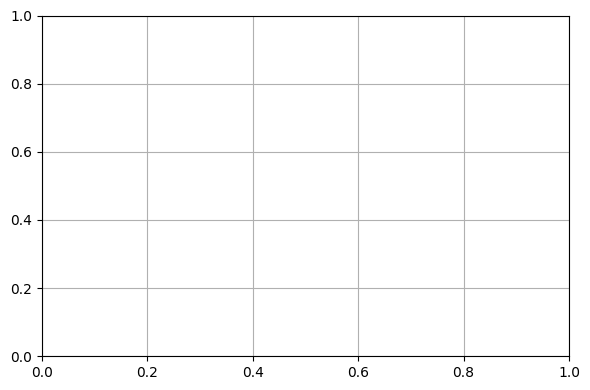

In [60]:
for i in range(5):
    
    fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(6, 4) )
    plt.grid(True)
    axs.scatter(times_flat[i][mask_qs[i]], times_reg[i][mask_qs[i]])
    plt.show()

In [ ]:
with h5.File(h5f,'r') as hf:
    chi2 = hf['pr-q3-9yr/gp'][:num,6]

print(chi2)

In [ ]:
# def get_exp_time_reco(t0, theta, phi, coords, mask, r_core, qs, a_curv, S_norm, rescale):
#     # flat
#     t_plane = t0 - tf.math.sin(theta)*( tf.math.cos(phi)*coords[:,:,:,0] + tf.math.sin(phi)*coords[:,:,:,1] ) - tf.math.cos(theta)*coords[:,:,:,2]
#     if tf.math.reduce_any( tf.math.is_nan( t_plane )):
#             print('t_plane Nan eval')
#     ## curvature
#     eta = get_eta(theta)
#     if tf.math.reduce_any( tf.math.is_nan( eta )):
#             print('eta Nan eval')
            
#     a_ivanov = get_a_ivanov(theta, rescale)
#     if tf.math.reduce_any( tf.math.is_nan( a_ivanov )):
#             print('a_ivanov Nan eval')
#     aprime = a_ivanov/tf.math.sqrt(S_norm)
#     if tf.math.reduce_any( tf.math.is_nan( aprime )):
#             print('aprime Nan eval')
#     s_prof = get_normed_ldf(dist_core, theta)
#     if tf.math.reduce_any( tf.math.is_nan( s_prof )):
#             print('s_prof Nan eval')
#     # time due to curvature
#     t_curv = aprime*get_lins_t( dist_core, s_prof )
#     if tf.math.reduce_any( tf.math.is_nan( t_curv )):
#             print('s_prof Nan eval')
    
#     return ( t_plane + t_curv * 1e-3*time2dist )*mask # nsec -> mks -> km 

In [ ]:
# # no t0
# t_0_mc = tf.constant([[[0.]]])
# # angles
# theta_mc = ev_params[:num,2][:,tf.newaxis, tf.newaxis]/180*3.1415
# phi_mc = ev_params[:num,3][:,tf.newaxis, tf.newaxis]/180*3.1415
# # aprime
# with h5.File(h5f,'r') as hf:
#     a_iv = hf['pr-q3-9yr/gp'][:num,6][:,tf.newaxis, tf.newaxis]
#     s_iv = hf['pr-q3-9yr/gp'][:num,2][:,tf.newaxis, tf.newaxis]
    
# aprime_reco = a_iv/tf.sqrt(s_iv)

In [ ]:
# print(aprime_reco[:5], a_iv[:5], s_iv[:5])